![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

# 1 Preprocesamiento de datos

In [1]:
# Importación librerías
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [3]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [4]:
# funcion para limpiar el texto
def clean_text(text):
    
    # Remueve un valor en particular encontrado en la exploracion " N"    
    text = re.sub("[.N]"," ",text)
    
    # Remueve todo menos el alfabeto
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    # Remueve los espacios en blanco
    text = ' '.join(text.split()) 
    
    # Remueve backslash-apostrofe
    text = re.sub("\'", "", text) 
    
    # convierte el texto en minuscula
    text = text.lower() 
    
    return text

dataTraining['clean_plot'] = dataTraining['plot'].apply(lambda x: clean_text(x))

In [5]:
def freq_words(x, terms = 100): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # Seleccionando el top 20 de las palabras mas repetidas
  d = words_df.nlargest(columns="Cantidad", n = terms) 
  
  # Visualizando las palabras y las repeticiones
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Palabra') 
  plt.show()

In [6]:
# nltk.download('stopwords')

In [7]:
stop_words = set(stopwords.words('english'))

# Funcion para remover las stop words
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

dataTraining['clean_plot'] = dataTraining['clean_plot'].apply(lambda x: remove_stopwords(x))

In [8]:
# freq_words(dataTraining['clean_plot'], 50)

In [9]:
##Cantidad de generos diferentes
all_genres = sum(dataTraining.genres,[])
all_genres = nltk.FreqDist(all_genres)
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [10]:
all_genres

FreqDist({'Drama': 3965, 'Comedy': 3046, 'Thriller': 2024, 'Romance': 1892, 'Crime': 1447, 'Action': 1303, 'Adventure': 1024, 'Horror': 954, 'Mystery': 759, 'Sci-Fi': 723, ...})

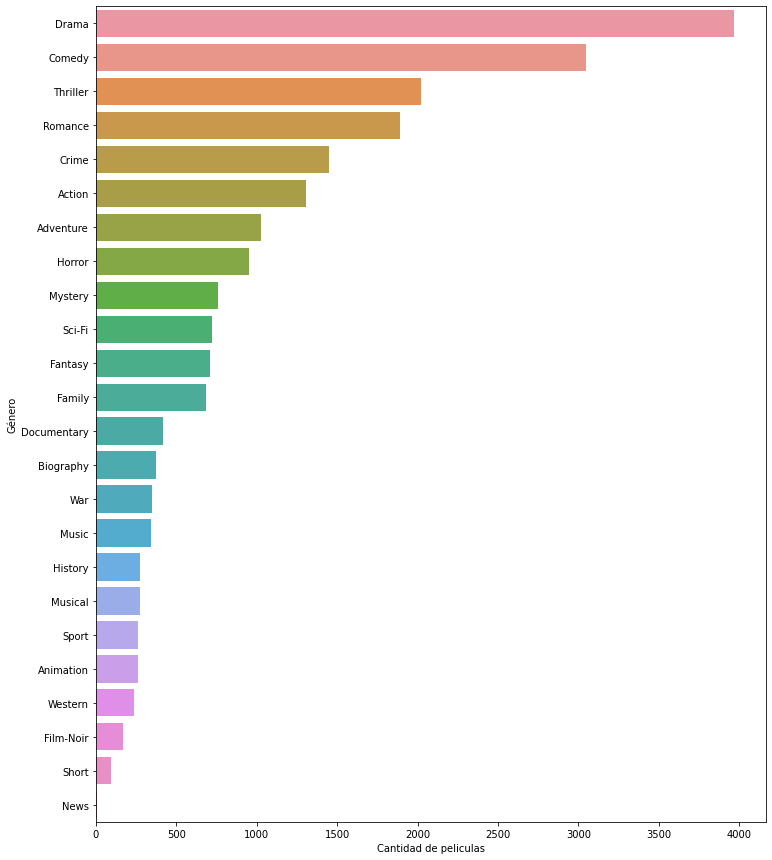

In [11]:
g = all_genres_df.nlargest(columns="Count", n = 24) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Género') 
ax.set(xlabel = 'Cantidad de peliculas') 
plt.show()

Se tienen 24 generos diferentes de películas


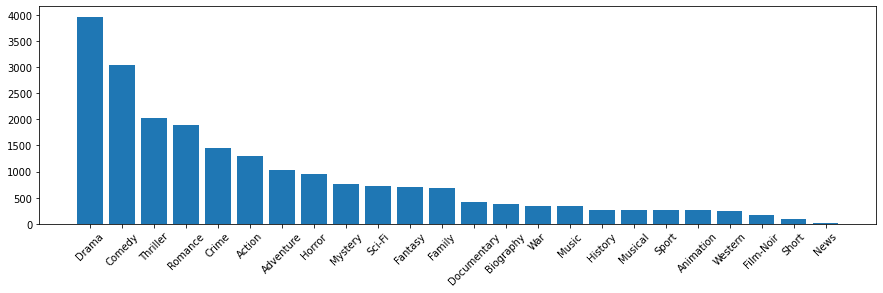

In [12]:
# Clases de género de películas
print('Se tienen', len(list(le.classes_)), 'generos diferentes de películas')

Resumen_Training = pd.DataFrame({"Género": list(le.classes_), "Cantidad": np.sum(y_genres, axis=0)})
Resumen_Training.sort_values(by=['Cantidad'], ascending=False, inplace=True)
x = Resumen_Training["Género"]
y = Resumen_Training["Cantidad"]
fig = plt.figure(figsize = (15,4))
ax = fig.add_subplot(111)
ax.bar(np.arange(len(x)),y)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45)
fig.show()

# Modelo MultiOutputClassifier

In [13]:
# Definir géneros para elaborar archivo para envío de predicciones a Kaggle

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

clases = len(cols)

In [14]:
# Función para extraer la predicción del MultiOutputClassifier

def extraer_prediccion(prediccion_MOclf, clases):
    datos_test = prediccion_MOclf[0].shape[0]
    resultado = np.full([datos_test, clases], None)
    for j in range(datos_test):
        prediccion_i = [] 
        for i in range(clases):
            prediccion_i.append(prediccion_MOclf[i][j][1])
        resultado[j] = prediccion_i
    
    return resultado


## Modelo sin calibrar

In [15]:
tf_vect_0 = TfidfVectorizer()

X_train_CV_0 = tf_vect_0.fit_transform(dataTraining['clean_plot'])


# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_train_CV_0, y_genres, test_size=0.20, random_state=42)


# In[17]:


# Definición del modelo de clasificación y ajuste de parámetros para calibración

MOclf = MultiOutputClassifier(LogisticRegression())

MOclf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
MOclf_predict = MOclf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, extraer_prediccion(MOclf_predict, clases), average='macro') 

0.8901960923648482

## Modelo calibrado

In [22]:
# Vectorización del plot limpio con TfId Vectorizer

tf_vect = TfidfVectorizer(ngram_range=(1,2),
                          norm='l2',
                          sublinear_tf=True,
                          max_df=0.95,
                          strip_accents='unicode',
                          tokenizer=nltk.word_tokenize,
                          decode_error='replace',
                          analyzer='word',
                          smooth_idf=True,
                          stop_words='english')
#                           sublinear_tf=True)

X_train_CV_1 = tf_vect.fit_transform(dataTraining['clean_plot'])

# Vistazo de los resultados del vectorizador

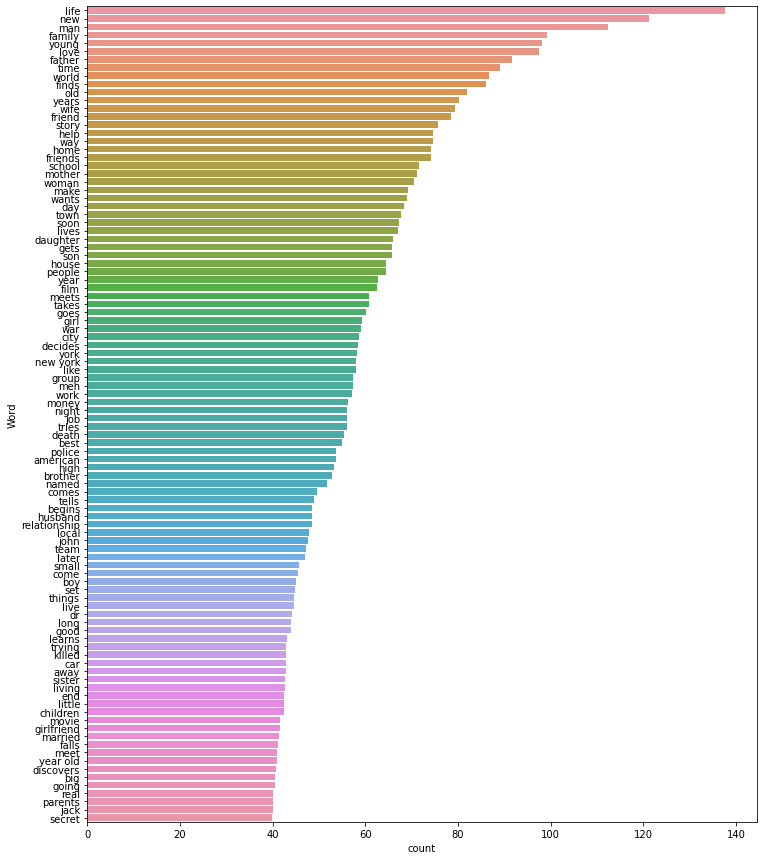

In [19]:
# para poder visualizar la grafica, cambiar los siguientes parametros en el vectorizador: max_df=0.95,min_df=10,
f=tf_vect.get_feature_names()
array_of_words = X_train_CV_1.toarray()
X_train_numpy=array_of_words
count_list = X_train_CV_1.toarray().sum(axis=0)
df_voc = pd.DataFrame()
df_voc['word'] = f
df_voc['count'] = count_list
df_voc = df_voc.sort_values(by=['count'],ascending=False).reset_index(drop=False)
terms=100

# Seleccionando el top 20 de las palabras mas repetidas
d = df_voc.nlargest(columns="count", n = terms) 

# Visualizando las palabras y las repeticiones
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=d, x= "count", y = "word") 
ax.set(ylabel = 'Word') 
plt.show()

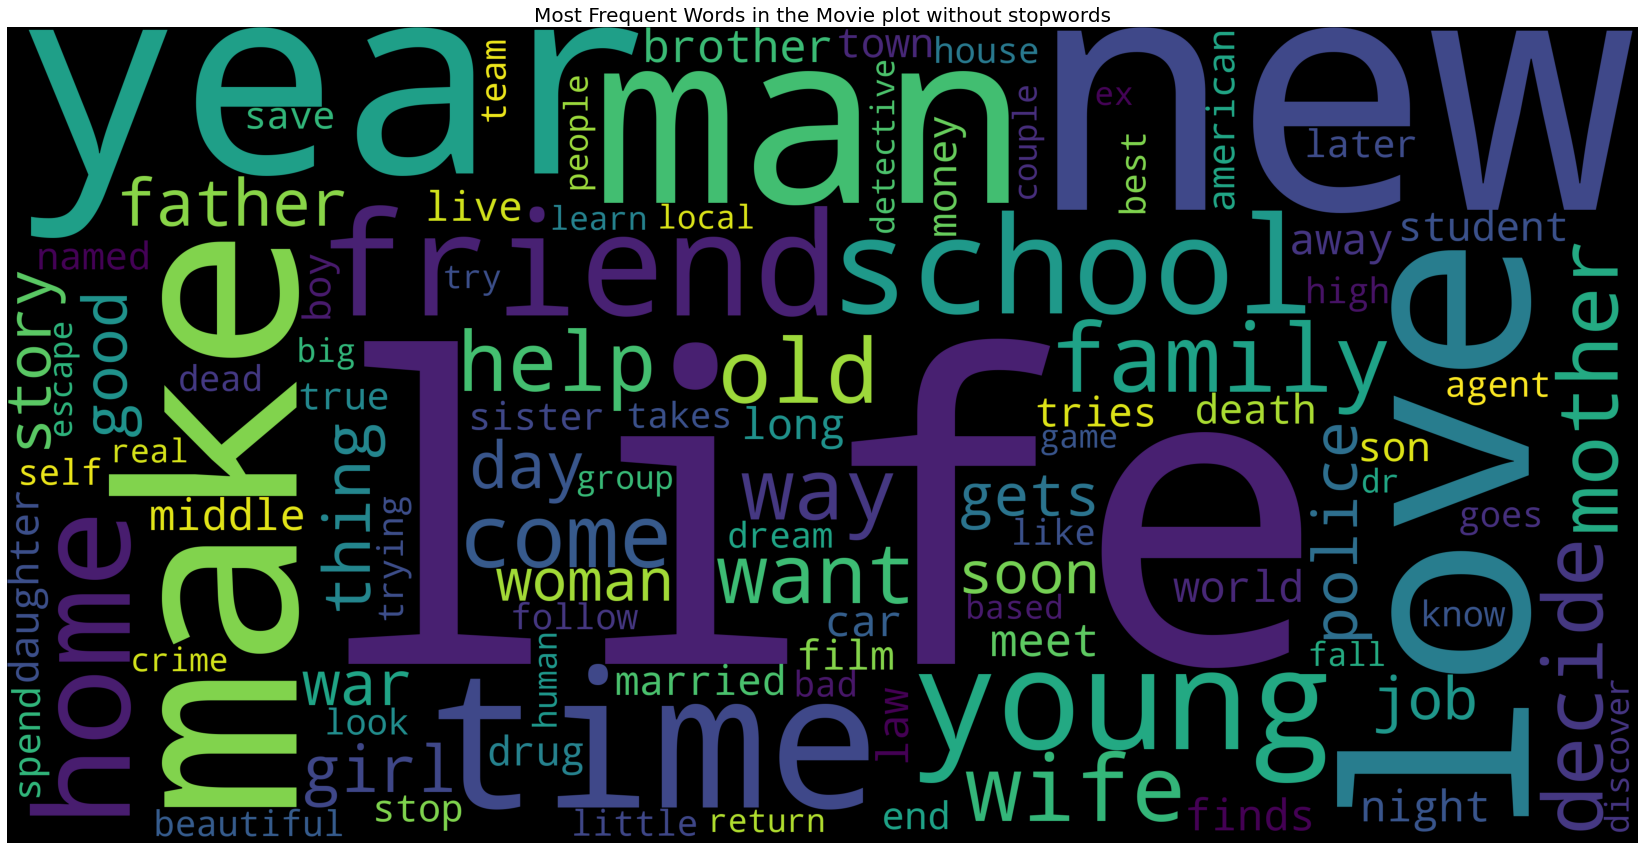

In [21]:
from wordcloud import WordCloud, STOPWORDS

title_corpus = ' '.join(df_voc['word'].tolist())
title_wordcloud = WordCloud(stopwords=stop_words, background_color='black', height=2000, width=4000, random_state = 42, max_words = 100).generate(title_corpus)

# Plot the wordcloud
fig, ax = plt.subplots(figsize=(30,15))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.title('Most Frequent Words in the Movie plot without stopwords', fontsize = 20)
plt.show()
fig.savefig('./MovieTitleCloudActiontfidf.png');

# Separacion de variables

In [23]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_train_CV_1, y_genres, test_size=0.20, random_state=42)

In [24]:
# Definición del modelo de clasificación y ajuste de parámetros para calibración

MOclf = MultiOutputClassifier(LogisticRegression(solver= 'newton-cg',
                                                 tol=0.05,
                                                 penalty='l2',
                                                 l1_ratio=1,
                                                 multi_class='multinomial',
                                                 C=10.2))

MOclf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
MOclf_predict = MOclf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, extraer_prediccion(MOclf_predict, clases), average='macro') 

0.8965666654387506

Exportar datos para subir a Kaggle

In [18]:
# Realizar predicciones y guardar en formato exigido en la competencia de kaggle

dataTesting['clean_plot'] = dataTesting['plot'].apply(lambda x: clean_text(x))
dataTesting['clean_plot'] = dataTesting['clean_plot'].apply(lambda x: remove_stopwords(x))
X_test_CV_1 = tf_vect.transform(dataTesting['clean_plot'])
y_pred_Kaggle = MOclf.predict_proba(X_test_CV_1)
res = pd.DataFrame(extraer_prediccion(y_pred_Kaggle, clases), index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_MOclf_v0.csv', index_label='ID')

Predecir una entrada de plot

In [19]:
# Para esta prueba se selecciona de manera aleatoria un plot de DataTesting para hacer la predicción
Entrada_API = dataTesting['clean_plot'][random.choice(dataTesting.index)]

# Limpieza y preprocesamiento
Entrada_API = clean_text(Entrada_API)
Entrada_API = [remove_stopwords(Entrada_API)]
Entrada_API = tf_vect.transform(Entrada_API)

# Realizar la predicción
Prediccion_API_prob = extraer_prediccion(MOclf.predict_proba(Entrada_API), clases).tolist()
Prediccion_API_prob = Prediccion_API_prob[0]
Prediccion_API_prob

[0.05409774821165333,
 0.004167397259114145,
 0.005990897921092045,
 0.005168291589676186,
 0.9447659138276459,
 0.7099795054536086,
 0.020166853270998274,
 0.23709637360446764,
 0.033299218607145686,
 0.019133457015694032,
 0.0076011084276667255,
 0.003206684114486074,
 0.011103299923422159,
 0.004293315322204052,
 0.004964889993435065,
 0.032128871627154595,
 0.00046778089791951836,
 0.09083239722486085,
 0.013482874834380529,
 0.00786046952468243,
 0.006685133648103338,
 0.30078111750488046,
 0.0035972131460922734,
 0.002605264806684851]

In [20]:
# Identificación de géneros

Prediccion_API = []
for i in range(len(Prediccion_API_prob)):
    if Prediccion_API_prob[i] >= 0.5:
        Prediccion_API.append(cols[i][2:])

# Resultado

Prediccion_API

['Comedy', 'Crime']